# Análise Titanic

**Introdução:** Este código avalia a sobrevivência dos passageiros que estavam no titanic durante seu naufrágio.

## Dataset analisado:

- PassengerId: Número de identificação do passageiro;
- Pclass     : Classe do passageiro no navio;
- Name       : Nome do passageiro;
- Sex        : Sexo do passageiro;
- Age        : Idade do passageiro;
- SibSp      : Número de irmãos/esposas no navio;
- Parch      : Número de pais/filhos no navio;
- Ticket     : Número do bilhete dos passageiros;
- Fare       : Valor pago pelo passageiro no bilhete;
- Cabin      : Cabine do passageiro no navio
- Embarked   : Local onde o passageiro embarcou.

## 1. Coleta de dados

In [1]:
#Desabilitando warnings indesejados.
import warnings
warnings.filterwarnings('ignore')

# Importando as bibliotecas para analisar os dados
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
#Importando os dados
trainFile = pd.read_csv("https://raw.githubusercontent.com/rayanmst/Titanic/master/train.csv", index_col = 'PassengerId')
testFile  = pd.read_csv("https://raw.githubusercontent.com/rayanmst/Titanic/master/test.csv", index_col = 'PassengerId')
combine = [trainFile, testFile]

#Verificando
trainFile.head()
testFile.head()

#Mostrando os gráficos no terminal
%matplotlib inline

In [3]:
#verificando dimensões do DataFrame
print(trainFile.shape)

(891, 11)


## 2. Definindo funções para gráficos

In [4]:
#Esta função serve para tornar a exibição de um map de correlações de maneira mais fácil
def plot_correlation_map(df):
    corr = trainFile.corr()
    _ , ax = plt.subplots(figsize =(12 , 10))
    cmap = sns.diverging_palette(220 , 10 , as_cmap = True)
    _ = sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={'shrink':.9}, ax=ax, annot = True, annot_kws = {'fontsize':12})

## 3. Analisando algumas colunas

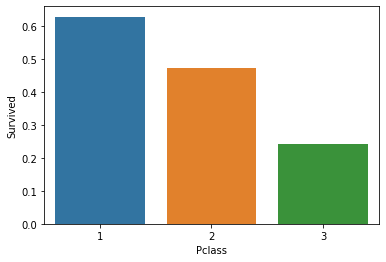

In [5]:
#Removendo colunas desnecessárias
del trainFile['Name']
del trainFile['SibSp']
del trainFile['Parch']
del trainFile['Cabin']
del trainFile['Ticket']
del testFile['Name']
del testFile['SibSp']
del testFile['Parch']
del testFile['Cabin']
del testFile['Ticket']

#Análise de relação entre classe e sobrevivência
classSurvivors = trainFile[['Pclass', 'Survived']].groupby(['Pclass'], 
      as_index=False).mean().sort_values(by='Survived', ascending=False)
sns.barplot(y = classSurvivors['Survived'], x = classSurvivors['Pclass'])

Text(0.5, 0, 'Age')

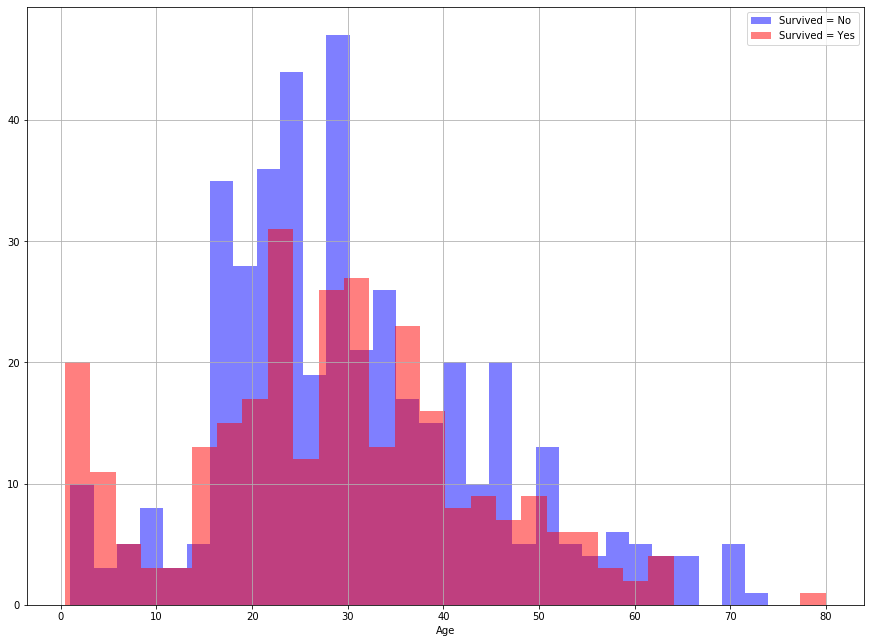

In [6]:
# Análise da coluna 'Survived' em relação a coluna 'Age'
plt.figure(figsize=(15, 11))
trainFile[trainFile['Survived']==0]['Age'].hist(alpha=0.5,color='blue', bins=30,label='Survived = No')
trainFile[trainFile['Survived']==1]['Age'].hist(alpha=0.5,color='red', bins=30,label='Survived = Yes')
plt.legend()
plt.xlabel('Age')

Text(0.5, 0, 'Fare')

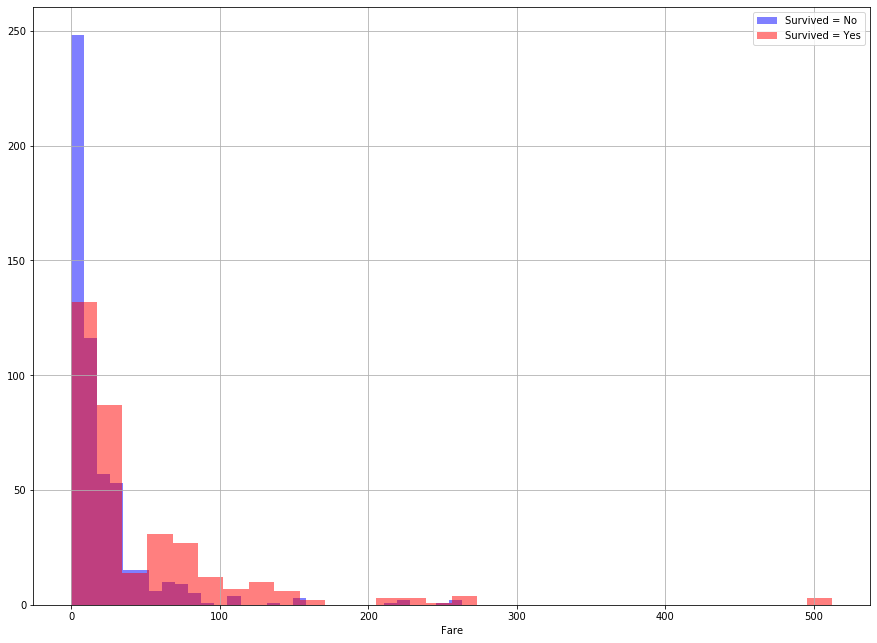

In [7]:
# Análise da coluna 'Survived' em relação a coluna 'Fare'
plt.figure(figsize=(15, 11))
trainFile[trainFile['Survived']==0]['Fare'].hist(alpha=0.5,color='blue', bins=30,label='Survived = No')
trainFile[trainFile['Survived']==1]['Fare'].hist(alpha=0.5,color='red', bins=30,label='Survived = Yes')
plt.legend()
plt.xlabel('Fare')

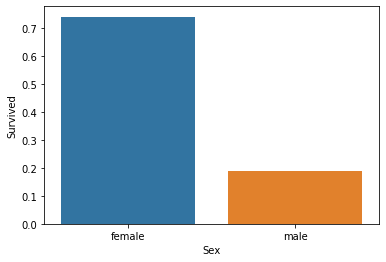

In [8]:
#Análise da porcentagem de passageiros sobreviventes de cada sexo
sexSurvivors = trainFile[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
sns.barplot(y = sexSurvivors['Survived'], x = sexSurvivors['Sex'])

## 4. Tratamento de dados

             Survived  Pclass  Sex   Age     Fare  Embarked
PassengerId                                                
1                   0       3    1  22.0   7.2500         2
2                   1       1    0  38.0  71.2833         0
3                   1       3    0  26.0   7.9250         2
4                   1       1    0  35.0  53.1000         2
5                   0       3    1  35.0   8.0500         2


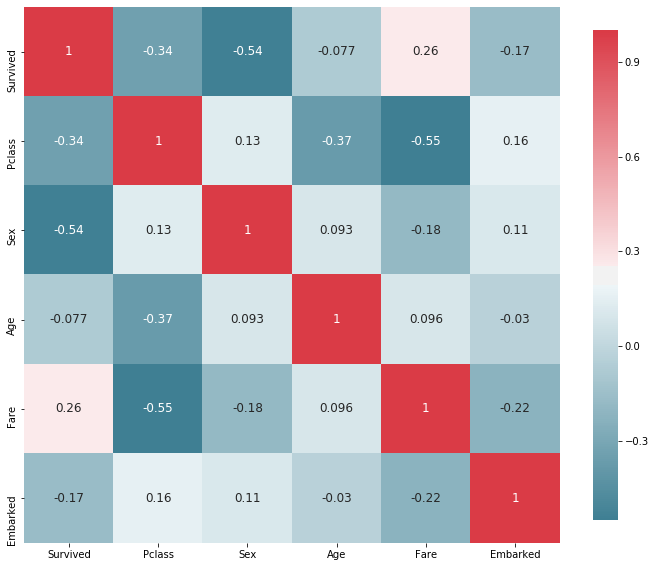

In [9]:
#Completando os dados faltantes em na coluna 'Embarked' com o valor mais comum da mesma.
trainFile['Embarked'].fillna('S', inplace = True)

#Mudança das variáveis do tipo objeto para numérico 
le = LabelEncoder()
for dataset in combine:
    for col in ['Sex', 'Embarked']:
        dataset[col] = le.fit_transform(dataset[col])

print(trainFile.head())    
plot_correlation_map(trainFile)


In [10]:
guess_ages = np.zeros((2,3))
for dataset in combine:
    for i in range(0,2):
        for j in range(0,3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_df.median()

            guess_ages[i,j] = int(age_guess/0.5 + 0.5)*0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

guess_fare = np.zeros((1,3))
for dataset in combine:
    for i in range(0,3):
        guess_df = dataset[(dataset['Pclass'] == i+1)]['Fare'].dropna()
        fare_guess = guess_df.mean()
    for i in range(0,3):
        dataset.loc[(dataset.Fare.isnull() & (dataset.Pclass == i+1)), 'Fare'] = guess_fare[0, i]        

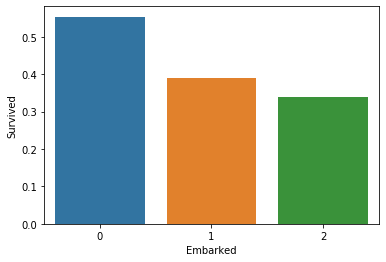

In [11]:
embarkSurvivors = trainFile[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)
sns.barplot(y = embarkSurvivors['Survived'], x = embarkSurvivors['Embarked'])

## 5. Predição de sobreviventes utilizando árvore de decisão

In [12]:
titanic_train, titanic_test = train_test_split(trainFile, test_size = 0.1, random_state = 150)

trainLbl = titanic_train.pop('Survived')
testLbl = titanic_test.pop('Survived')
#Instanciando a árvore de decisão
DTC = dtc(max_depth= 5)

#Treinando o modelo
DTC = DTC.fit(titanic_train, trainLbl)

#Testando o modelo
predict = DTC.predict(titanic_test)
tst = accuracy_score(testLbl, predict)

## 6. Avaliando os resultados

In [13]:
confusion = pd.DataFrame(confusion_matrix(testLbl, predict), 
                         columns = ['Survived prediction', 'Death prediction'], 
                         index = ['Survived', 'Died'])
acc = accuracy_score(testLbl, predict)
pre = precision_score(testLbl, predict)
rec = recall_score(testLbl, predict)
f1Scr = f1_score(testLbl, predict)
print(f'Accuracy = {acc*100: .2f}%\nPrecision = {pre*100: .2f}%')
print(f'Recall = {rec*100: .2f}%\nF1 Score = {f1Scr*100: .2f}%')

confusion

Accuracy =  90.00%
Precision =  96.30%
Recall =  76.47%
F1 Score =  85.25%


,Survived prediction,Death prediction
Survived,55,1
Died,8,26


## 7. Exportando a árvore

In [15]:
with open('decision_tree.txt', 'w') as f:
    f = export_graphviz(DTC, out_file=f, class_names = ['Survived', 'Died'],
                        filled = True, feature_names = list(titanic_test.columns))
    print('Done')

Done
